In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pandahouse as ph
import scipy.stats as ss
from pingouin import compute_bootci
from urllib.parse import urlencode
import requests

%matplotlib inline 

## Задание 1. A/B–тестирование

### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

* groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
* groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

* На какие метрики Вы смотрите в ходе анализа и почему?
* Имеются ли различия в показателях и с чем они могут быть связаны?
* Являются ли эти различия статистически значимыми?
* Стоит ли запускать новую механику на всех пользователей?

In [2]:
# Загрузим все данные

# Файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-amirmetov-37/groups.csv', sep=';')

# Дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
groups_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-amirmetov-37/groups_add.csv')

# Файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-amirmetov-37/active_studs.csv', sep=';')

# Файл с информацией об оплатах пользователей в дни проведения эксперимента. 
checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-amirmetov-37/checks.csv', sep=';')

In [3]:
# Посмотрим на данные

dict_data = {'groups': groups, 
             'groups_add': groups_add, 
             'active_studs': active_studs, 
             'checks': checks}

for name, data in dict_data.items():
    print(name)
    display(data.head(10))

groups


,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
5,1803,B
6,1805,B
7,2067,A
8,2078,A
9,2080,B


groups_add


,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
5,5699132,B
6,5699712,B
7,5700613,B
8,5700771,B
9,5701056,B


active_studs


,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
5,5481015
6,1353433
7,1394612
8,1170611
9,491277


checks


,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
5,100645,630.0
6,102534,580.0
7,106837,290.0
8,108270,290.0
9,114366,690.0


In [4]:
# Функция для проверки датафрейма на пропуски и дубликаты

def check_data(df):
    print(f"Типы данных: {df.dtypes}")
    print(f"Размер таблицы: {df.shape}")
    print(f"Количество пропусков: {df.isna().sum()}")
    print(f"Количество дубликатов id: {df.iloc [:, 0].duplicated().sum()}")

In [5]:
# Ни в одной из таблиц не было обнаружено дубликатов в столбце с id пользователей или пропусков 

In [6]:
check_data(groups)

Типы данных: id      int64
grp    object
dtype: object
Размер таблицы: (74484, 2)
Количество пропусков: id     0
grp    0
dtype: int64
Количество дубликатов id: 0


In [7]:
check_data(groups_add)

Типы данных: id      int64
grp    object
dtype: object
Размер таблицы: (92, 2)
Количество пропусков: id     0
grp    0
dtype: int64
Количество дубликатов id: 0


In [8]:
check_data(active_studs)

Типы данных: student_id    int64
dtype: object
Размер таблицы: (8341, 1)
Количество пропусков: student_id    0
dtype: int64
Количество дубликатов id: 0


In [9]:
check_data(checks)

Типы данных: student_id      int64
rev           float64
dtype: object
Размер таблицы: (541, 2)
Количество пропусков: student_id    0
rev           0
dtype: int64
Количество дубликатов id: 0


In [10]:
# Проверим, входят ли id из groups_add в id groups
any(item in groups_add.id.to_list() for item in groups.id.to_list())

False

In [11]:
# Результат False. Значит в groups_add добавочные данные. Объединим groups и groups_add
groups = pd.concat([groups, groups_add], ignore_index=True)

In [12]:
# Переименуем столбец student_id в id в active_studs и checks
active_studs = active_studs.rename(columns={'student_id':'id'})
checks = checks.rename(columns={'student_id':'id'})

In [13]:
# объединим все данные для последующих вычислений так, чтобы остались id активных пользователей
final_df = active_studs.merge(checks, how='left', left_on='id', right_on='id') \
         .merge(groups, how='left', left_on='id', right_on='id')

In [14]:
# Все nan значения заполиним нулями
final_df.fillna(0, inplace=True)

In [15]:
final_df

,id,rev,grp
0,581585,0.0,A
1,5723133,0.0,A
2,3276743,0.0,B
3,4238589,0.0,A
4,4475369,0.0,B
...,...,...,...
8336,1794344,0.0,B
8337,296883,0.0,B
8338,3598448,0.0,B
8339,3610547,290.0,B


Учитывая, что имеются данные только о тратах пользоваталей, для анализа результатов эксперимента я выбрал две метрики:
* CR - проверим, увеличивает ли новая модель оплаты конверсию пользователя в покупку 
* ARPPU - проверим, влияет ли на средний чек платящих клиентов новая механика

In [16]:
# Для подсчета метрик добавим колонку paid, где 1 - пользователь совершил покупку, 0 - не было покупок
final_df['paid'] = final_df.rev.apply(lambda x: 1 if x > 0 else 0)

In [17]:
final_df.head(10)

,id,rev,grp,paid
0,581585,0.0,A,0
1,5723133,0.0,A,0
2,3276743,0.0,B,0
3,4238589,0.0,A,0
4,4475369,0.0,B,0
5,5481015,0.0,B,0
6,1353433,0.0,B,0
7,1394612,0.0,A,0
8,1170611,0.0,B,0
9,491277,0.0,B,0


In [18]:
# Для каждой группы посчитаем количество денег, который внесли пользователи, количество платящих пользователей 
# и суммарное количество пользователей
df_metrics = final_df.groupby('grp', as_index=False) \
    .agg({'rev': 'sum', 'paid': 'sum', 'id': 'count'}) \
    .rename(columns={'id': 'users'})

In [19]:
# Вычислим CR и ARPPU в группах
df_metrics['CR'] = df_metrics.paid / df_metrics.users * 100 
df_metrics['ARPPU'] = df_metrics.rev / df_metrics.paid

In [20]:
df_metrics

,grp,rev,paid,users,CR,ARPPU
0,A,72820.0000,78,1538,5.071521,933.589744
1,B,394974.0035,314,6803,4.615611,1257.878992


## Проверка разницы в CR

Для проверки различий CR между группами воспользуемся критерем Хи-квадрат(наблюдений больше 5, переменная категориальная(купил, не купил), наблюдения независимы)

Выдвинем нулевую и альтернативную гипотезы:
* H0 - новый метод оплаты не влияет на решение клиента о покупке
* H1 - новый метод оплаты влияет на решение клиента о покупке

Уровень значимости a = 0.05

In [21]:
# Подготовим таблицу сопряженности
test_df = pd.crosstab(final_df.grp, final_df.paid)

In [23]:
# 0 - была покупка, 1 - покупки не было
test_df

paid,0,1
grp,,
A,1460,78
B,6489,314


In [29]:
# Результат выполнения Хи-квадрат
ss.chi2_contingency(test_df)

(0.48480826522557896,
 0.48625240457231045,
 1,
 array([[1465.71897854,   72.28102146],
        [6483.28102146,  319.71897854]]))

p-value больше 0.05 - нет оснований, чтобы отклонить нулевую гипотезу. 
То есть разница в CR вероятно не зависит от нового механизма оплаты.



## Проверим разницу в ARPPU

Выдвинем нулевую и альтернативную гипотезы:

* H0 - разницы между средними чеками нет
* H1 - разница межлу средними чеками есть

Уровень значимости a = 0.05

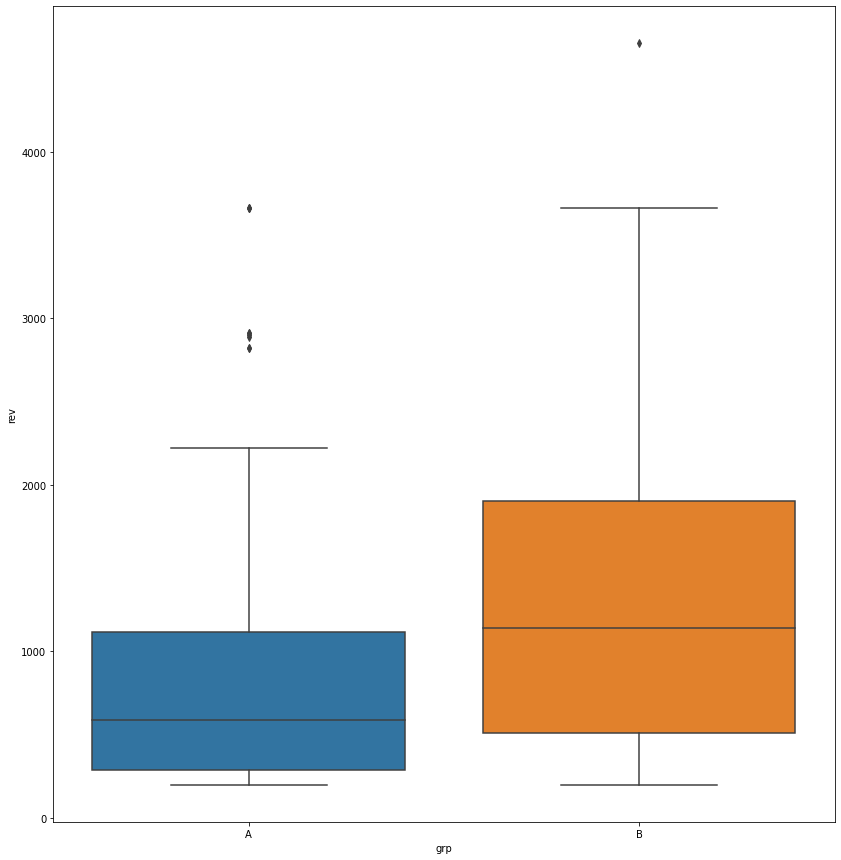

In [30]:
# Посмотрим на выборки платежей в каждой группе
plt.figure(figsize=(14, 15))
sns.boxplot(data=final_df.query('rev > 0'), x='grp', y='rev')

Боксплот показал, что в каждой группе есть заметные выбросы, особенно много их в районе 3000.

In [55]:
# В группе А 10 человек выходят за усы графика. Стоит уточнить в какое время данные покупатели оплачивали услугу. 
# Возможно была в тот момент акция. Удалять эти данные из выборки не будем.
final_df.query('rev > 2000 and grp == "A"')

,id,rev,grp,paid
392,332387,2910.0,A,1
591,1624158,3660.0,A,1
1606,2150601,3660.0,A,1
1673,4002619,2890.0,A,1
2093,347455,2820.0,A,1
2206,594228,2900.0,A,1
3481,2455897,2820.0,A,1
3674,3355197,2220.0,A,1
7950,445767,3660.0,A,1
8025,1202202,2910.0,A,1


In [36]:
# В группе B только один человек выходит за рамки. Удалять из выборки не будем, ведь неясна природа данной оплаты. 
final_df.query('rev > 4000 and grp == "B"')

,id,rev,grp,paid
3988,1711305,4650.0,B,1


Text(0.5, 1.0, 'group A')

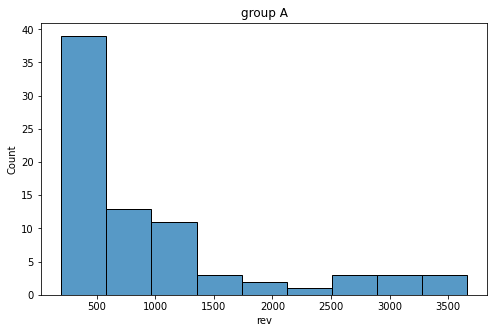

In [66]:
# Рассмотрим распределения revenue в каждой группе
plt.figure(figsize=(8, 5))
sns.histplot(data=final_df.query('rev > 0 and grp == "A"'), x='rev')
plt.title('group A')

Text(0.5, 1.0, 'group B')

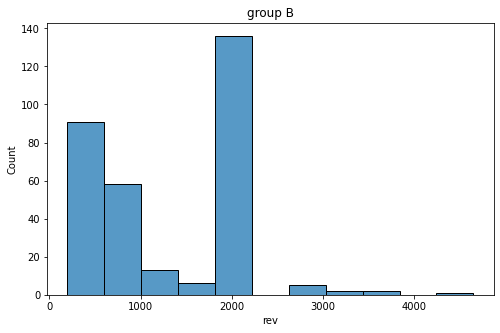

In [44]:
plt.figure(figsize=(8, 5))
sns.histplot(data=final_df.query('rev > 0 and grp == "B"'), x='rev')
plt.title('group B')

In [48]:
# Распределения не похожи на нормальные. Используем критерий Шапиро-Уилка для проверки на нормальность
res = ss.shapiro(final_df.query('rev > 0 and grp == "A"').rev)

In [49]:
res.pvalue

1.4986822893803264e-10

In [52]:
res = ss.shapiro(final_df.query('rev > 0 and grp == "B"').rev)

In [53]:
res.pvalue

1.5437024585965894e-16

Ни одно из распределений по критерию Шапиро-Уилка нельзя назвать нормальным. Для проверки статзначимости разницы в ARPPU у групп можно использовать либо критерий Манна-Уитни, либо bootstrap. Я выберу bootstrap.

In [63]:
compute_bootci(final_df.query('rev > 0 and grp == "A"').rev, func = "mean")

array([ 728.54, 1139.72])

In [64]:
compute_bootci(final_df.query('rev > 0 and grp == "B"').rev, func = "mean")

array([1173.62, 1344.2 ])

Так как доверительные интервалы не пересекаются, то можно отклонить нулевую гипотезу

## Вывод:

Для каждой группы были посчитаны метрики CR(конверсия в покупку) и ARPPU(средний доход с платящего пользователя). 
Статистическая значимость в метриках у групп была оценена с помощью Хи-квадрата и Bootstrap.
CR у контрольной группы больше, чем у целевой, но разница не статзначима. 
ARPPU у контрольной группы ниже, чем у целевой, разница статзначима.
С одной стороны конверсия в покупку упала(но статистика показала, что новая модель оплаты скорее всего не влияет на эту разницу), но увеличился средний чек с платящих пользователей. Однако в данных о платежах в целевой группе оказались выбросы и скачок чеков в районе 500, как и в данных целевой группы(большое количество чеков в районе 2000), что наталкивает на сомнения о корректности проведения аб тестирования. Стоит уточнить, были ли в дни проведения тестирования акции на сайте. Полагаю, что достаточных оснований для ввода новой механики оплаты нет, ведь неясно, влияет ли именно она на имеющися результаты.

## Задание 2. SQL
### 2.1 Очень усердные ученики.

#### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

#### 2.1.2 Задача

Дана таблица default.peas:
| Название атрибута | Тип атрибута | Смысловое значение                       |
|-------------------|--------------|------------------------------------------|
| st_id             | int          | ID ученика                               |
| timest            | timestamp    | Время решения карточки                   |
| correct           | bool         | Правильно ли решена горошина?            |
| subject           | text         | Дисциплина, в которой находится горошина |

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [24]:
# Установим соединение с базой данных default в clickhouse
connection = dict(host = 'https://clickhouse.lab.karpov.courses',
                  database = 'default',
                  user = 'student', 
                  password = 'dpo_python_2020')

In [29]:
# В подзапросе вычислим в каждом месяце сумму решенных задач у ученика, оставим только "усердных" и отфильтруем по последнему месяцу. 
# После из подзапроса посчитаем количество "усердных" учеников.
query_1 = """
SELECT 
    COUNT(st_id) AS excellent_students
FROM
(SELECT
    toStartOfMonth(timest) AS month,
    st_id,
    SUM(correct) AS sum_of_success
 FROM peas
 GROUP BY 
    month, 
    st_id
 HAVING sum_of_success >= 20
    AND month = MAX(toStartOfMonth(timest)))
"""

In [30]:
excellent_students = ph.read_clickhouse(query=query_1, connection=connection)
excellent_students

,excellent_students
0,136


## 2.2 Оптимизация воронки

### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

### 2.2.2 Задача

Дана таблицы: default.peas (см. выше), default.studs:

| Название атрибута | Тип атрибута | Смысловое значение                   |
|-------------------|--------------|--------------------------------------|
| st_id             | int          |  ID ученика                          |
| test_grp          | text         |  Метка ученика в данном эксперименте |

и default.final_project_check:

| Название атрибута | Тип атрибута | Смысловое значение                     |
|-------------------|--------------|----------------------------------------|
| st_id             | int          | ID ученика                             |
| sale_time         | timestamp    | Время покупки                          |
| money             | int          | Цена, по которой приобрели данный курс |
| subject           | text         |                                        |

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

* ARPU 
* ARPAU 
* CR в покупку 
* CR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
* ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [3]:
# Опишем подзапрос. В нем в начале берется таблица studs, к которой будет добавляться информация для каждого студента с помощью join.
# В таблице peas для каждого студента найдем суммарное количество решенных задач и количество решенных задач по математике и c помощью left join
# присоеденим к таблице studs полученные данные.
# В таблице final_project_check найдем полученную с каждого студента суммарную прибыль и прибыль за курс математики. 
# Присоединим эти данные к предыдущей таблице с помощью left join.
# Затем, используя данные из соединенных таблиц, высчитаем все необходимые метрики для групп.
query_2 = '''
SELECT
    a.test_grp AS test_grp,
    SUM(c.money_per_user) / uniqExact(a.st_id) AS ARPU,
    SUM(CASE WHEN b.correct_tasks > 10 THEN c.money_per_user END) / COUNT(CASE WHEN b.correct_tasks > 10 THEN 1 END) AS ARPAU,
    (COUNT(CASE WHEN c.money_per_user > 0 THEN 1 END) / uniqExact(a.st_id)) * 100 AS CR,
    (COUNT(CASE WHEN b.correct_tasks > 10 AND c.money_per_user > 0 THEN 1 END) / COUNT(CASE WHEN b.correct_tasks > 10 THEN 1 END)) * 100 AS CR_of_active_users,
    (COUNT(CASE WHEN b.correct_tasks_math >= 2 AND c.money_per_user_math > 0 THEN 1 END) / COUNT(CASE WHEN b.correct_tasks_math >= 2 THEN 1 END)) * 100 AS CR_of_math_active_users
FROM
(SELECT *
FROM
    studs a
LEFT JOIN 
    (SELECT 
        st_id,
        SUM(correct) AS correct_tasks,
        SUM(CASE WHEN subject = 'Math' THEN correct END) AS correct_tasks_math
     FROM
        peas
     GROUP BY 
        st_id) b
ON a.st_id = b.st_id
LEFT JOIN 
    (SELECT
        st_id,
        SUM(money) AS money_per_user,
        SUM(CASE WHEN subject = 'Math' THEN money END) AS money_per_user_math
     FROM 
        final_project_check
     GROUP BY 
        st_id) c
ON a.st_id = c.st_id)
GROUP BY a.test_grp
'''

In [4]:
metrics = ph.read_clickhouse(query=query_2, connection=connection)
metrics

,test_grp,ARPU,ARPAU,CR,CR_of_active_users,CR_of_math_active_users
0,control,4540.983607,10393.700787,4.918033,11.023622,6.122449
1,pilot,11508.474576,29739.583333,10.847458,26.041667,9.523810


## Задание 3. Python
### 3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики. 

In [126]:
def get_metrics():
    
    # Загрузка датасетов
    groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-amirmetov-37/groups.csv', sep=';')
    groups_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-amirmetov-37/groups_add.csv')
    active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-amirmetov-37/active_studs.csv', sep=';')
    checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-amirmetov-37/checks.csv', sep=';')
    
    #Переименуем первую колонку в таблицах groups_add, active_studs, checks в id и переименуем вторую колонку в groups_add в grp
    active_studs = active_studs.rename(columns={active_studs.columns[0]:'id'})
    checks = checks.rename(columns={checks.columns[0]:'id'})
    groups_add = groups_add.rename(columns={groups_add.columns[0]:'id', groups_add.columns[1]:'grp'})
    
    # объединяем groups и groups_add
    groups = pd.concat([groups, groups_add], ignore_index=True)
    
    # Объединим все данные для последующих вычислений так, чтобы остались id активных пользователей
    final_df = active_studs.merge(checks, how='left', left_on='id', right_on='id') \
               .merge(groups, how='left', left_on='id', right_on='id')
    
    
    # Все nan значения заполиним нулями
    final_df.fillna(0, inplace=True)
    
    # Для подсчета метрик добавим колонку paid, где 1 - пользователь совершил покупку, 0 - не было покупок
    final_df['paid'] = final_df.rev.apply(lambda x: 1 if x > 0 else 0)
    
    # Для каждой группы посчитаем количество денег, который внесли пользователи, количество платящих пользователей 
    # и суммарное количество пользователей
    df_metrics = final_df.groupby('grp', as_index=False) \
                 .agg({'rev': 'sum', 'paid': 'sum', 'id': 'count'}) \
                 .rename(columns={'id': 'users'})
    
    df_metrics['CR'] = df_metrics.paid / df_metrics.users * 100 
    df_metrics['ARPPU'] = df_metrics.rev / df_metrics.paid
    
    return df_metrics

In [127]:
get_metrics()

,grp,rev,paid,users,CR,ARPPU
0,A,72820.0000,78,1538,5.071521,933.589744
1,B,394974.0035,314,6803,4.615611,1257.878992


2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [150]:
def draw_charts(df_metrics):
    sns.set(
        style='whitegrid',
        font_scale = 1.5
        )
    
    fig, axs = plt.subplots(ncols=2, figsize=(20,8))
    
    sns.barplot(data=df_metrics, x='grp', y='CR', ax=axs[0]).set(xlabel='', ylabel='', title='CR')
    sns.barplot(data=df_metrics, x='grp', y='ARPPU', ax=axs[1]).set(xlabel='', ylabel='', title="ARPPU")

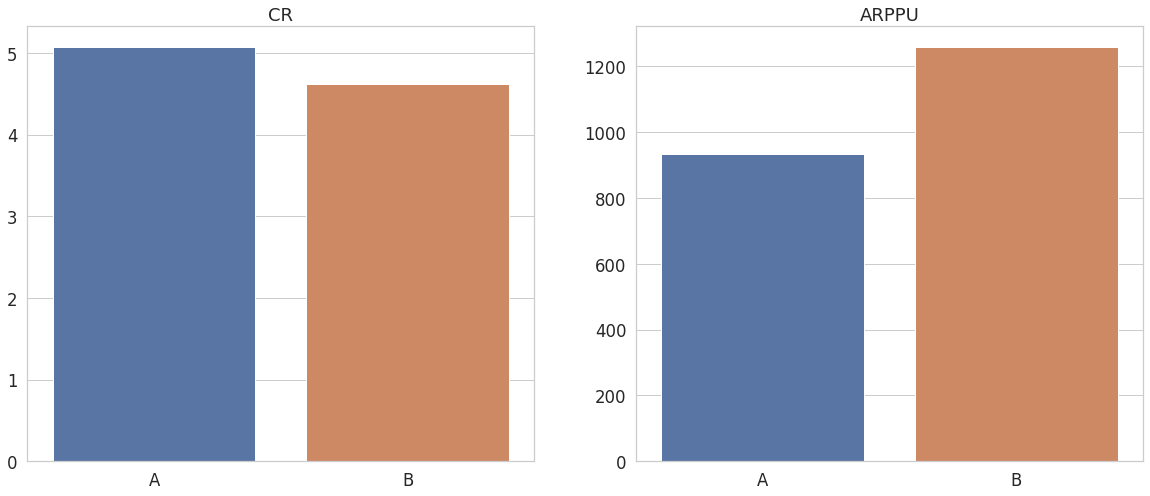

In [152]:
metrics_data = get_metrics()[['grp', 'CR', 'ARPPU']]
draw_charts(metrics_data)